### TODO
- Everything
- Drop users that have rated very few movies -> How to decide the threshold?
- Define the best approach to the collaborative filtering (model-based or memory-based)
- Build the recommender system (can it be as simple as kNN?)

### DONE
- File loading and creation of the DataFrame

In [52]:
# Imports
import os
import gc
import sys
import math

# from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from surprise import Reader, Dataset, SVD, KNNWithMeans, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV


# # Not being used yet.
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.pipeline import Pipeline

# from scipy.sparse import csr_matrix

# from scipy.spatial import Voronoi, voronoi_plot_2d
# from imblearn.over_sampling import SMOTE

sns.set_theme(style="darkgrid")

In [53]:
# Read Movie Titles file
def readMovieTitle(file_path):
    data_dict = {'Movie_Id' : [], 'Release_Year' : [], 'Title' : []}
    data_file = open(file_path, "r", encoding='ISO-8859-1')
    for line in data_file:            
        id, year, title = line.split(',', 2)
        data_dict['Movie_Id'].append(id)
        data_dict['Release_Year'].append(year)
        data_dict['Title'].append(title.rstrip('\n'))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [54]:
# The dataset is very large, so there's a flag to load only a handful of rows if necessary
# First 1M lines takes 0.2s to load, the whole dataset takes almost 2 minutes
cid_list = {}
def readFile(file_path, rows = 1000000, flag = False):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    data_file = open(file_path, "r")
    count = 0
    for line in data_file:
        count += 1
        if flag and (count > rows):
            break
            
        if ':' in line:
            movieId = line[:-2] # remove the last character ':'
            movieId = int(movieId)
        else:
            customerID, rating, date = line.split(',')
            if (customerID not in cid_list):
                cid_list[customerID] = 1
            else:
                cid_list[customerID] += 1
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [55]:
# Load the title of the movies into a dataframe
df_title = readMovieTitle('data/movie_titles.csv')
df_title['Movie_Id'] = df_title['Movie_Id'].astype(int)
df_title.head(10)
# df_title.loc[df_title['Movie_Id'] == 1]

,Movie_Id,Release_Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
6,7,1992,8 Man
7,8,2004,What the #$*! Do We Know!?
8,9,1991,Class of Nuke 'Em High 2
9,10,2001,Fighter


In [56]:
# Loading the user data
# User ID, Movie ID, Rating and Date
flag_limit = True
df = readFile('data/combined_data_all.txt', flag = flag_limit)
# Transform everything to INT, occupies less RAM.
df['Rating'] = df['Rating'].astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

In [57]:
# Creation of the DataFrame with all the data
df.index = np.arange(0,len(df))
df.head(10)
# Drop everything but the essential information
df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Rating']]
original = df

# # Complete Dataframe with the movie titles
# # Not necessary
# df = df.merge(df_title, how='left')
# df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Title', 'Release_Year', 'Rating', 'Date']]
# df.head(-10)

# Too much data, so I'm deleting the dataframes after the merge
# In total it uses 14gb of memory
# Explicitily calling the garbage collector to free up RAM
gc.collect()

633464

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999775 entries, 0 to 999774
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Cust_Id   999775 non-null  int64
 1   Movie_Id  999775 non-null  int64
 2   Rating    999775 non-null  int64
dtypes: int64(3)
memory usage: 30.5 MB


After the successful loading of the data into a single large dataframe, now it's time to understand the data and do a little bit of a clean up (delete rows with NaN values, look for duplicates, drop unnecessary columns etc.)

In [59]:
# General format of the Dataframe
df.head(10)

,Cust_Id,Movie_Id,Rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
5,893988,1,3
6,124105,1,4
7,1248029,1,3
8,1842128,1,4
9,2238063,1,3


In [60]:
df.shape

(999775, 3)

In [61]:
# Check the type of the variables.
# Here we identify that some are loaded as a type we don't want and thus need to transform it
# Int occupies less memory
df.dtypes

Cust_Id     int64
Movie_Id    int64
Rating      int64
dtype: object

In [62]:
# KNN
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
trainset = data.build_full_trainset()

param = {'name':'cosine', 'user_based':False}
knn = KNNBasic(sim_options=param)
knn.fit(trainset)

cross_validate(knn, data, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1400  1.1392  1.1425  1.1397  1.1403  1.1403  0.0012  
MAE (testset)     0.8846  0.8850  0.8867  0.8841  0.8853  0.8852  0.0009  
Fit time          0.23    0.52    0.52    0.52    0.52    0.46    0.12    
Test time         2.12    2.94    2.99    2.12    3.02    2.64    0.42    


{'test_rmse': array([1.13997281, 1.13917877, 1.14252104, 1.13966647, 1.14029076]),
 'test_mae': array([0.88464027, 0.88499256, 0.88667434, 0.88414774, 0.88532102]),
 'fit_time': (0.22893929481506348,
  0.5164978504180908,
  0.5166056156158447,
  0.522911548614502,
  0.5228252410888672),
 'test_time': (2.1197121143341064,
  2.943342924118042,
  2.9879088401794434,
  2.118340492248535,
  3.0225088596343994)}

In [63]:
# show results on random user
random_user = df_title.copy()
random_user = random_user.reset_index()

random_user['Estimate_Score'] = random_user['Movie_Id'].apply(lambda x: knn.predict(305344, x).est)[:225]

random_user = random_user.sort_values('Estimate_Score', ascending=False)
print(random_user[['Movie_Id', 'Title', 'Estimate_Score']].head(20))

     Movie_Id                                           Title  Estimate_Score
14         15                Neil Diamond: Greatest Hits Live        3.061273
98         99                                   A Fishy Story        2.964362
146       147                         Where Sleeping Dogs Lie        2.892408
152       153                                        MTV Yoga        2.841437
93         94                             G3: Live in Concert        2.836009
86         87                               Louder Than Bombs        2.804850
118       119               Travel the World by Train: Africa        2.725787
202       203       Sports Illustrated Swimsuit Edition: 1997        2.723478
30         31      Classic Albums: Meat Loaf: Bat Out of Hell        2.710462
135       136                              Cat and the Canary        2.698993
195       196               Peter Tosh: Stepping Razor: Red X        2.602394
48         49     Devo: The Complete Truth About De-evolution   

In [64]:
# basic svd, default parameters
svd = SVD()
svd.fit(trainset)
cross_validate(svd, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9879  0.9885  0.9825  0.9864  0.9871  0.9865  0.0021  
MAE (testset)     0.7716  0.7727  0.7705  0.7711  0.7737  0.7719  0.0012  
Fit time          10.52   10.14   10.75   10.25   10.61   10.45   0.23    
Test time         2.02    0.94    0.96    0.94    0.94    1.16    0.43    


{'test_rmse': array([0.9879499 , 0.98848676, 0.98254157, 0.98638948, 0.98707492]),
 'test_mae': array([0.77156463, 0.77273494, 0.77047786, 0.77107851, 0.77366531]),
 'fit_time': (10.519972562789917,
  10.141262531280518,
  10.749834299087524,
  10.24598240852356,
  10.605041742324829),
 'test_time': (2.0167856216430664,
  0.9367775917053223,
  0.9604594707489014,
  0.943371057510376,
  0.9392342567443848)}

In [65]:
# Grid Search to find the best parameters for SVD
param_grid = {
    "n_epochs": [5, 20],
    "lr_all": [0.002, 0.01],
    "reg_all": [0.2, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])


0.9765353808034748
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


In [66]:
# run svd again but with new parameters
opt = gs.best_params["rmse"]
svd = SVD(n_epochs=opt["n_epochs"], lr_all=opt["lr_all"], reg_all=opt["reg_all"])
svd.fit(trainset)
cross_validate(svd, data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9728  0.9733  0.9754  0.9715  0.9767  0.9739  0.0019  
MAE (testset)     0.7676  0.7677  0.7695  0.7658  0.7713  0.7684  0.0019  
Fit time          10.31   10.06   11.04   10.51   10.95   10.57   0.37    
Test time         2.01    2.05    2.08    0.96    0.96    1.61    0.53    


{'test_rmse': array([0.97277074, 0.97325959, 0.97542883, 0.97150085, 0.97669553]),
 'test_mae': array([0.76755501, 0.76773153, 0.76954848, 0.7657756 , 0.77129046]),
 'fit_time': (10.312148809432983,
  10.05708384513855,
  11.038317918777466,
  10.51296353340149,
  10.95428991317749),
 'test_time': (2.0131826400756836,
  2.052044630050659,
  2.0820248126983643,
  0.961512565612793,
  0.9560861587524414)}

In [67]:
# show results on random user
random_user = df_title.copy()
random_user = random_user.reset_index()

random_user['Estimate_Score'] = random_user['Movie_Id'].apply(lambda x: svd.predict(305344, x).est)

random_user = random_user.sort_values('Estimate_Score', ascending=False)
print(random_user[['Movie_Id', 'Title', 'Estimate_Score']].head(20))

     Movie_Id                                              Title  \
12         13  Lord of the Rings: The Return of the King: Ext...   
105       106  Stevie Ray Vaughan and Double Trouble: Live at...   
208       209               Star Trek: Deep Space Nine: Season 5   
75         76                              I Love Lucy: Season 2   
134       135                  GTO: Great Teacher Onizuka: Set 2   
84         85                                         Elfen Lied   
214       215                           That '70s Show: Season 1   
222       223                         Chappelle's Show: Season 1   
31         32  ABC Primetime: Mel Gibson's The Passion of the...   
166       167                                         The Chorus   
32         33                     Aqua Teen Hunger Force: Vol. 1   
24         25      Inspector Morse 31: Death Is Now My Neighbour   
36         37                              Zatoichi's Conspiracy   
67         68                                   

Now the dataset is clean (it already was, but nonetheless this should be part of the pipeline)
Let's investigate the data, i.e. do Feature Understanding
Histogram, KDE, Boxplot

In [ ]:
df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).mean()

48.53465346534654

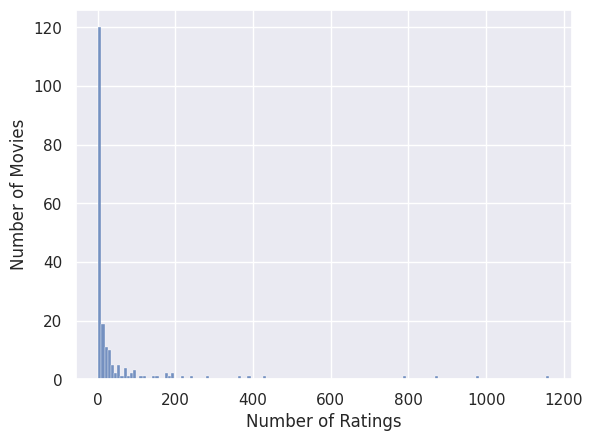

In [ ]:
mr = df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).head(14000)

ax = sns.histplot(data=mr)
ax.bar_label(ax.containers[0])
plt.axis('on')
plt.xlabel('Number of Ratings')
plt.xscale('linear')
plt.ylabel('Number of Movies')
plt.show()

In [ ]:
mr.tail(10)

df_title.loc[(df_title['Movie_Id'] == 5317)]

,Movie_Id,Release_Year,Title
5316,5317,2000,Miss Congeniality


In [ ]:
# Number of unique movies
movie_count = df['Movie_Id'].nunique()

# Number of unique customers
cust_count = df['Cust_Id'].nunique()

# Number of ratings
rating_count = df['Cust_Id'].count()

# How many ratings for each value (1-5)
rating_dist = df['Rating'].value_counts().sort_index()

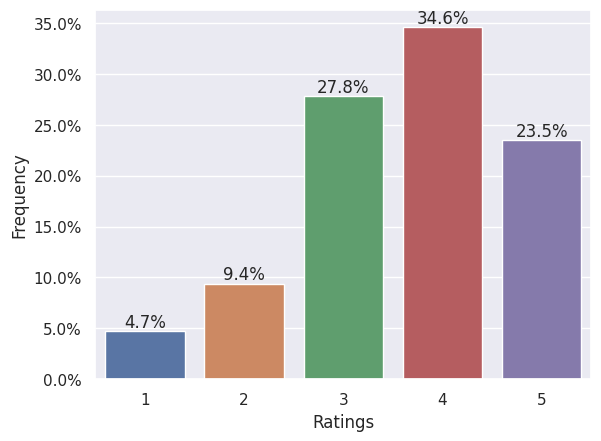

In [ ]:
# Histogram of the frequency of ratings
rd = [(i/sum(rating_dist)*100) for i in rating_dist]

ax = sns.barplot(x = np.arange(1,len(rd)+1), y = rd)
ax.bar_label(ax.containers[0], fmt = '%.1f%%')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.axis('on')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()


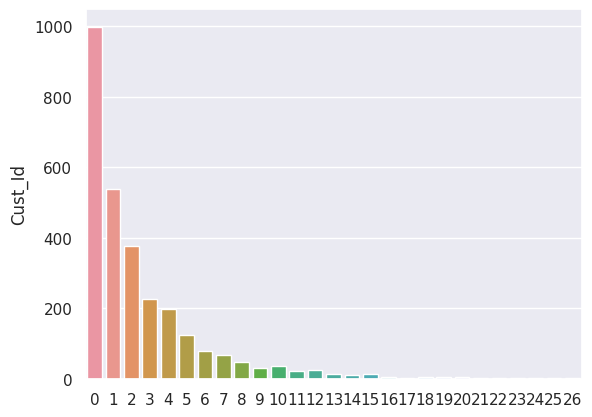

In [ ]:
# Histogram of the frequency of reviews by users
cust_rating_dist = df['Cust_Id'].value_counts().sort_values()

crd = cust_rating_dist.value_counts().sort_index()

ax = sns.barplot(x = np.arange(len(crd)), y = crd) 
plt.show()

The data is pretty huge, after understanding it's intrincacies, we've decided to work only with the movies and users that were in the 75% quantile

In [ ]:
f = ['count','mean']
quantile = 0.75

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(quantile),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(quantile),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 26.0
Customer minimum times of review: 4.0


In [ ]:
# Checking the favorite movies of a random user (df['Cust_Id'].mode() -> users with most reviews)
df.loc[(df['Cust_Id'] == 305344) & (df['Rating'] >= 4)].reset_index(drop=True)

,Cust_Id,Movie_Id,Rating


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9804 entries, 18 to 999630
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Cust_Id   9804 non-null   int64
 1   Movie_Id  9804 non-null   int64
 2   Rating    9804 non-null   int64
dtypes: int64(3)
memory usage: 306.4 KB


In [ ]:
df = original.copy()

# df.info()

# Reducing the dataset so it works with reasonable RAM consumption
drop_percentage = 0.99
train_percentage = 0.99
cid_as_int = list(map(lambda x: int(x), cid_list.keys()))
cid_as_str = list(map(lambda x: x, cid_list.keys()))
cid_df = pd.DataFrame(data={"Cust_Id": cid_as_int})

# print(cid_df)
arr_cid_to_drop = default_rng().choice(cid_df.index, size=(math.floor(len(cid_df)*drop_percentage)), replace=False)
cid_df.drop(index=arr_cid_to_drop, inplace=True)
mask1 = df["Cust_Id"].isin(cid_df["Cust_Id"].tolist())
df = df[df["Cust_Id"].isin(cid_df["Cust_Id"].tolist())]
# df.info()

arr_cid_train = default_rng().choice(cid_df.index, size=(math.floor(len(cid_df)*(1 - train_percentage))), replace=False)
cid_train_df = cid_df.drop(index=arr_cid_train, inplace=False)
mask = df["Cust_Id"].isin(cid_train_df["Cust_Id"].tolist())
df_train = df[df["Cust_Id"].isin(cid_train_df["Cust_Id"].tolist())]
df_test = df[~df["Cust_Id"].isin(cid_train_df["Cust_Id"].tolist())]
# for everyone in df_test:
#     remove 1 rated movie
cids_to_remove_rating = list(dict.fromkeys(list(df_test["Cust_Id"])))
print(cids_to_remove_rating)
df_users = []
tuples = []
# for i in range(len(cids_to_remove_rating)):
#     cid = cids_to_remove_rating[i]
#     df_users[cid] = df[df["Cust_Id"] == cid].copy()
#     a = df_users[cid].sample()
#     print(a)
#     print(df_users[cid])
#     print(a.index[0])
#     tuples.append([cid, a.at[a.index[0],"Movie_Id"], a.at[a.index[0],"Rating"]])
#     print(tuples)
#     df_users[cid].loc[a.index[0],"Rating"] = 0

for i in range(len(cids_to_remove_rating)):
    cid = cids_to_remove_rating[i]
    df_users.append(df[df["Cust_Id"] == cid].copy())
    a = df_users[i].sample()
    tuples.append([a.index[0], cid, a.at[a.index[0],"Movie_Id"], a.at[a.index[0],"Rating"]])
    df_users[i].drop(index=[a.index[0]], inplace=True)

print(tuples)
df_reconstructed = pd.concat(df_users)
print(df_reconstructed)
print(df_train)
df_final = pd.concat([df_train, df_reconstructed])
print(df_final)
#     df_test
# print(df_test)
# df_test["Cust_Id"]
# print(df_test)

[802242, 1166750, 2250951, 1189649, 1150749, 1711751, 1764736, 1143782, 2134728, 1955609, 2626313, 926434, 1164290, 331853, 764817, 2218827, 530159, 2579932, 2561460, 1063931, 627985, 1280902, 2345097, 309296, 1632807, 1505705, 276416, 2517157]
[[565906, 802242, 167, 4], [462268, 1166750, 143, 4], [115798, 2250951, 30, 3], [224059, 1189649, 40, 3], [78776, 1150749, 28, 5], [92504, 1711751, 29, 3], [546342, 1764736, 165, 3], [105901, 1143782, 30, 2], [589821, 2134728, 175, 5], [575344, 1955609, 173, 4], [265757, 2626313, 58, 4], [157034, 926434, 30, 3], [933435, 1164290, 199, 5], [222215, 331853, 37, 4], [240916, 764817, 46, 5], [243647, 2218827, 47, 3], [601598, 530159, 175, 2], [335962, 2579932, 88, 4], [413735, 2561460, 116, 3], [583549, 1063931, 175, 2], [450631, 627985, 133, 5], [453414, 1280902, 138, 4], [923636, 2345097, 199, 4], [694389, 309296, 187, 2], [667222, 1632807, 175, 5], [765721, 1505705, 191, 2], [892254, 276416, 197, 4], [827899, 2517157, 197, 4]]
        Cust_Id  Mo

In [ ]:
# success rates
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_train[['Cust_Id', 'Movie_Id', 'Rating']], reader)
# dataTest = Dataset.load_from_df(df_test[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainingSet = data.build_full_trainset()
# testSet = dataTest.build_full_trainset()
svd = SVD()
svd.fit(trainingSet)
# svd.fit(trainingSet).test(testSet)

successTimes = 0

for i in range(len(tuples)):
    index = tuples[i][0]
    cid = tuples[i][1]
    movId = tuples[i][2]
    rating = tuples[i][3]
    est = svd.predict(cid, movId).est
    print(f"Customer {cid}, Film {movId}. Real evaluation: {rating}. Predicted: {est}")
    # floor + 0.5 = closest integer
    if math.floor(est + 0.5) == rating:
        successTimes = successTimes + 1
#     print(svd.predict(cid, movId).est)

print(f"Success rate: {successTimes / len(tuples)}")

Customer 802242, Film 167. Real evaluation: 4. Predicted: 4.1871549935896955
Customer 1166750, Film 143. Real evaluation: 4. Predicted: 3.9335386580997915
Customer 2250951, Film 30. Real evaluation: 3. Predicted: 3.78662537097388
Customer 1189649, Film 40. Real evaluation: 3. Predicted: 3.522251009644367
Customer 1150749, Film 28. Real evaluation: 5. Predicted: 3.8377513888067716
Customer 1711751, Film 29. Real evaluation: 3. Predicted: 3.692529290693758
Customer 1764736, Film 165. Real evaluation: 3. Predicted: 4.080148484811493
Customer 1143782, Film 30. Real evaluation: 2. Predicted: 3.78662537097388
Customer 2134728, Film 175. Real evaluation: 5. Predicted: 4.035820762549432
Customer 1955609, Film 173. Real evaluation: 4. Predicted: 3.7222563910266264
Customer 2626313, Film 58. Real evaluation: 4. Predicted: 3.59700727946249
Customer 926434, Film 30. Real evaluation: 3. Predicted: 3.78662537097388
Customer 1164290, Film 199. Real evaluation: 5. Predicted: 3.96501572304087
Customer 